## 7.1 앙상블 학습
    o 앙상블 학습의 목표 : 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성
### 과반수 투표
    o 분류기의 과반수 또는 다수결로 예측한 클래스 레이블을 선택하는 단순한 방법 
    o 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정
    o 11개(n=11)의 p(ε) = 0.25인 이항분포 각 분류기의 과반수가 에러가 발생할 확률은 k >6 일 때  즉 0.034 
        0.25 -> 0.034로 급감
    ex) 서로 다른 결정 트리를 연결한 랜덤 포레스트 


In [3]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    # 이항분포의 과반수 값을 계산
    k_start = int(math.ceil(n_classifier / 2.))
    # 이항분포의 과반수 이상의 확률을 계산
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)] 
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

    o 앙상블과 개별 분류기 에러 사이의 관계 선 그래프로 시각화

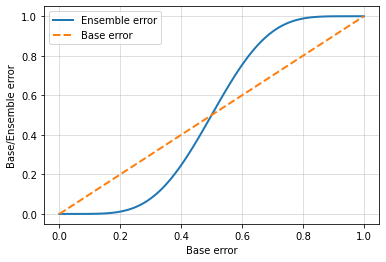

In [4]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## 7_2 다수결 투표를 사용한 분류 앙승블

### ● 간단한 다수결 투표 분류기 구현
    o 구현할 알고리즘은 여러 가지 분류 모델의 신뢰도에 가중치를 부여하여 연결 
    o 특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축하는 것이 목표
<img src='../img_수식/다수결 투표.PNG'>  

    o W_j는 개별 분류기 C_j에 연관된 가중치, y_hat는 앙상블이 예측한 클래스 레이블, Χ_Α는 특성 함수, A는 고유한 클래스 레이블 집합
    o 가중치가 모두 동일 하면 
<img src='../img_수식/다수결 투표2.PNG'>  

- argmax, bincount 함수를 사용하여 가중치가 적용된 다수결 투표를 파이썬 코드로 구현

In [5]:
np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

- 앙상블이 분류기가 잘 보정된(예측값의 비율이 실제값의 비율이 동일한) 다수결 투표에서 클래스 레이블 대신 예측 클래스 확률을 사용하는 것이 좋음

<img src='../img_수식/다수결 투표3.PNG'>   

- 넘파이 average와 armax 함수를 사용하여 클래스 확률을 기반으로 가중치가 적용된 다수결 투표


In [6]:

ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [9]:
np.argmax(p)

0

#### 이들을 모두 결합하여 MajorityVoteClassfier 파이썬 클래스를 구현해 봅시다.

In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [11]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers] ex) [LogistRegression, DecisionTree, KNN]
      앙상블에 사용할 분류기

    vote : str, {'classlabel', 'probability'}
      기본값: 'classlabel'
      'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다.
      'probability'이면 확률 합이 가장 큰 인덱스로 
      클래스 레이블을 예측합니다(보정된 분류기에 추천합니다).

    weights : 배열 타입, 크기 = [n_classifiers]
      선택사항, 기본값: None
      `int` 또는 `float` 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다.
      `weights=None`이면 동일하게 취급합니다.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        # 코드 _name_estimators([LogisticRegression,LogisticRegressionCV]) 실행시
        #  [('type-1', sklearn.linear_model._logistic.LogisticRegression),('type-2', sklearn.linear_model._logistic.LogisticRegressionCV)] 가 출력
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬

        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터

        반환값
        -------
        self : 객체

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다."
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기 개수와 가중치 개수는 동일해야 합니다.'
                             '; %d개의 가중치와, %d개의 분류기가 입력되었습니다.'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때 
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬

        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            #  clf.predict 메서드를 사용해 결과를 모읍니다.
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다.

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수이고 n_features는 특성의 개수인
            샘플 데이터 행렬

        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해서 분류기의 매개변수 이름을 반환합니다"""
        if not deep: # deep == False
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### ● 다수결 투표 방식을 사용하여 예측 만들기

- 데이터셋 불러오기, 데이터 분할 및 라벨인코딩

In [17]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

- 서로 다른 세 분류기

        o 로지스틱 회귀 분류기  
        o 결정 트리 분류기    
        o k-최근접 이웃 분류기
        

- 각 분류기를 앙상블로 묶기 전에 훈련 세트에서 10-겹 교차 검증으로 성능을 평가 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [20]:
clf1 = LogisticRegression(solver='liblinear',
                          penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))
    


10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


#### ※로지스틱 회귀와 k-최근접 이웃 분류기는 왜 파이프 라인?
- 로지스틱 회귀와 k-최근접법은 결정 트리와 달리 스케일에 민감 -> 붓꽃 데이터셋의 특성이 모두 같으 스케일(cm)로 측정되었지만 특성을 표준화 전처리하는 것은 좋은 습관임

#### 이 장의 핵심 => 다수결 투표 앙상블을 위해 MajorityVoteClassifier 클래스로 각 분류기를 하나로 연결

In [21]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


##### ※ 결과에서 보듯이 10-겹 교차 검증으로 평가했을 때 MajorityVoteClassifier의 성능이 개별 분류기보다 뛰어남

### 앙상블 분류기의 평가와 튜닝
- MajorityVoteClassifier의 일반화 성능을 확인하기 위해 ROC 곡선을 그려봄  ＃ 테스트 세트는 모델 선택에 사용하지 않았음
- 테스트 세트의 목적은 편향되지 않은 분류기의 일반화 성능을 추정하기 위해서입니다.

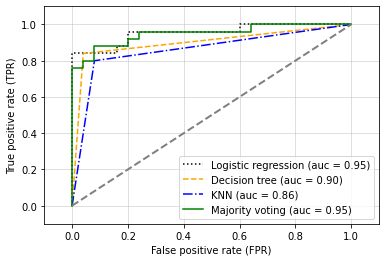

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

로지스틱 회귀와 과반수 투표 앙상블이 비슷한 성능을 내는 이유는 아마도 작은 데이터셋에서 생기는 높은 분산 때문임

- 이진 분류이므로 결정경계 확인 가능
    
    o 결정 트리의 결정 결계를 다른 모델과 같은 스케일로 나태내기 위해 표준화 과정 필요
    

In [23]:

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

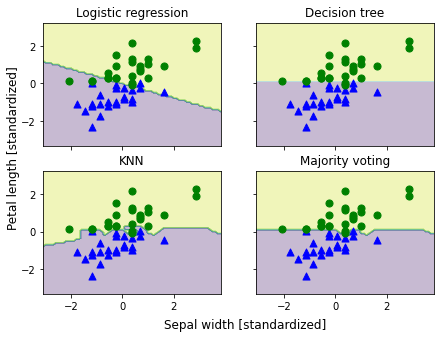

In [24]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

앙상블을 위해 개별 분류기의 매개 변수를 튜닝하기 전에 GridSearchCV 객체 안에 있는 매개변수에 어떻게 접근할 수있는지 get_params 메서드를 호출해서 알아봄

In [43]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf',
                  LogisticRegression(C=0.001, random_state=1,
                                     solver='liblinear')]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1, solver='liblinear')]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf_

***
get_params 메서드에서 반환되는 값을 살펴보자 -> 개별 분류기의 속성에 접근하는 방법을 알 수 있음  
예시를 보이기 위해 그리드 서치로 로지스틱 회귀 분류기의 규제 매개변수 C와 결정트리의 깊이를 튜닝
***

In [44]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))


0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


C:\Users\jye12\anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [45]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}